# Exploring The Data and Feature Engineering

This notebook is for cleaning the scraped data and engineering features that will help determine the level. The features I will be engineering are: presence of different verb tenses, frequency of most common Spanish words, average sentence length, and proportion of unique words in the text.

## First Steps

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize

In [3]:
#import files containing the texts and their levels and concatanate them.
#files containing rl were scraped from readlang, a language text sharing site
#df_other and A1_A2_other were scraped from various different different websites
df_rl_A1 = pd.read_csv (r'./scraping/readlang_A1.csv')
df_rl_A2 = pd.read_csv (r'./scraping/readlang_A2.csv')
df_rl_B1 = pd.read_csv (r'./scraping/readlang_B1.csv')
df_rl_B2 = pd.read_csv (r'./scraping/readlang_B2.csv')
df_rl_C1 = pd.read_csv (r'./scraping/readlang_C1.csv')
df_rl_C2 = pd.read_csv (r'./scraping/readlang_C2.csv')
df_other = pd.read_csv(r'./scraping/spanish_reading_texts.csv')
A1_A2_other = pd.read_csv(r'./scraping/A1_A2_test.csv')

frames = [df_rl_A1, df_rl_A2, df_rl_B1, df_rl_B2, df_rl_C1, df_rl_C2, df_other, A1_A2_other]
df = pd.concat(frames, ignore_index=True)

In [4]:
df.head()

,Level,Text
0,A1,Hazlo por tu padre o por tu madre.Aguanta por ...
1,A1,Hola
2,A1,1. ¿En qué se parece un esqueleto a una comida...
3,A1,Hola soy Beatriz y estamos al frente de la Igl...
4,A1,Hola. Nos encontramos en Lima Perú en el distr...


In [5]:
df.describe()

,Level,Text
count,636,630
unique,7,625
top,B2,Mientras estoy en la escuela tenemos un descan...
freq,139,3


In [6]:
#Drop all duplicate values as they are likely non-useful
df = df.drop_duplicates(subset='Text')

#Replace new line formatting with full stops so poems and songs will not be treated as one continous sentence
df = df.replace('\n', '. ', regex=True)

#Drop all null values
df = df.dropna()

df.describe()

,Level,Text
count,625,625
unique,7,625
top,B2,158 comentariosVer comentarios**. La ANC sigue...
freq,137,1


In [7]:
#Need to check why there are 7 different levels
df.Level.value_counts()

B2    137
B1    128
C1    114
A2    112
C2     94
A1     35
?!      5
Name: Level, dtype: int64

In [8]:
#Can't tell what the levels labelled as '?!' actually are so will drop them
print(df[df.Level == '?!'])

    Level                                               Text
499    ?!  Julieta ¿Julieta? ¡Bea! No me lo puedo creer ¿...
536    ?!  Bernarda declara ocho años de luto [Bernarda] ...
561    ?!  Arabismos Cuando pensamos en la cultura árabe ...
571    ?!  Despacito [Fonsi:] Sí sabes que ya llevo un ra...
578    ?!  La Familia Addams - premier en Madrid Reporter...


In [9]:
df = df[df.Level != '?!']
df.describe()

,Level,Text
count,620,620
unique,6,620
top,B2,158 comentariosVer comentarios**. La ANC sigue...
freq,137,1


### Verb Tenses with The Part Of Speech Tagger
Spanish learners are introduced to different tenses gradually as they get better. As such, the presence of different tenses in a text should give us insight into it's level.

The Stanford POS tagger will analyse the texts word by word and return a code representing what part of speech the word falls under (this will label all verbs and their tenses). The function below will use this and then return counts for the verb tenses present in each text as well as other variables that will be useful for later engineering. The POS tagger will also highlight most non-Spanish texts that might be present, as it will get stuck when trying to tag them, using a timeout system these texts can be identified and later deleted. 

Computationally expensive! Takes about 5s per text.

In [10]:
#Import and setup the POStagger.

#StanfordPOSTagger is best for Spanish. However, it needs to be accessed through Java
from nltk.tag import StanfordPOSTagger
jar = '/Users/davidhunter/Downloads/stanford-postagger-full-2018-10-16/stanford-postagger-3.9.2.jar'
model = '/Users/davidhunter/Downloads/stanford-postagger-full-2018-10-16/models/spanish.tagger'

import os
java_path = "/System/Library/Frameworks/JavaVM.framework/Versions/Current/Commands/java"
os.environ["JAVAHOME"] = java_path

#tags each word by word type 
#codes can be found here: https://web.archive.org/web/20160325024315/http://nlp.lsi.upc.edu/freeling/doc/tagsets/tagset-es.html
#In the above list the last 3 digits are always set to 000 in this tagger. It does not provie that last level of specificity
pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8' )

#Testing
pos_tagger.tag('voy a decir'.split())    

[('voy', 'vmip000'), ('a', 'sp000'), ('decir', 'vmn0000')]

In [11]:
#Function to check the tenses present in the text
#Uses the StanfordPOStagger
#Would get stuck if the text was non-Spanish, included timout feature to account for this 
from collections import Counter
import signal

#Set empty dictionary to store the non Spanish id's for deletion later
non_spanish = []

#Generous time limit
timelimit_seconds = 20

#Classes and functions for the time out process
class TimeoutException(Exception):
    pass

def signal_handler(signum, frame):
    raise TimeoutException()

#Tense checking function, takes a text (words) and a number for identification purposes (z)
def TenseChecker(text, z=0):
    
    #Checks for 0 values and adds them to delete list.
    if text == 0:
        text = 'hola'
        non_spanish.append(z)
    
    #Sets and starts the timer
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(timelimit_seconds)
    
    try:
        #words is a tuple list of the words and their codes
        words = pos_tagger.tag(text.split())
        
        length = len(words)

        #list of just the codes for counting
        codes = [x[1] for x in words]
        
        #Creating a list of each word for later use
        words_list = [x[0] for x in words]
        
        #Counts the frequencies of each verb code
        counter = Counter(codes)
        
        #Creates a total count for each verb tense using the counter
        imperfect_past = counter['vmii000'] + counter['vsii000'] + counter['vaii000']
        simple_past = counter['vmis000'] + counter['vsis000'] + counter['vais000']
        simple_future = counter['vmif000'] + counter['vsif000'] + counter['vaif000']
        conditional = counter['vmic000'] + counter['vsic000'] + counter['vaic000']
        present_subjunctive = counter['vmsp000'] + counter['vssp000'] + counter['vasp000']
        imperfect_subjunctive = counter['vmsi000'] + counter['vssi000'] + counter['vasi000']
        gerund = counter['vmg0000'] + counter['vsg0000'] + counter['vag0000']
        imperative = counter['vmm0000'] + counter['vsm0000'] + counter['vam0000']
        present_simple = counter['vmip000'] + counter['vsip000'] + counter['vaip0000']
        
        total_verbs = imperfect_past + simple_past + simple_future + conditional + present_subjunctive + gerund + imperfect_subjunctive + imperative + present_simple
        
        #Turn off the alarm
        signal.alarm(0)
        
        #dictionary containing the frequency of verb tenses and the length of the text
        frequencies = {'imperfect_past': imperfect_past, 'simple_past': simple_past, 'simple_future': simple_future,
                      'conditional': conditional, 'present_subjunctive': present_subjunctive, 'imperfect_subjunctive': imperfect_subjunctive,
                      'gerund': gerund, 'imperative': imperative, 'present_simple': present_simple, 'length': length,
                      'total_verbs': total_verbs, 'words_list': words_list, 'tags': words}
    
    #If it takes too long and the alarm is triggered, the index is added to the non_spanish list for later deletion.
    except TimeoutException:
        frequencies = 0
        non_spanish.append(z)
     
    return frequencies
    

In [12]:
#Computationally expensive, use minimally.
df['tense_frequencies'] = df.apply(lambda row: TenseChecker(row['Text'], row.name), axis=1)

In [13]:
print(len(non_spanish))

15


In [14]:
#drop non-Spanish values
df = df.drop(df.index[non_spanish])

#Save file after computation
df.to_csv('tagged_texts.csv', index=False, header=False)

### Post POSTagging
Now that the verb tenses are saved in the dataframe I will start trying to manipulate that data into useful values. Firstly, the tense counts need to be extracted from the dictionary 'Tense_frequencies'.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.read_csv(r'./tagged_texts.csv', names=['Level', 'Text', 'Tense_frequencies'])

#Need to remove 0 values for tense frequencies
df.describe()

,Level,Text,Tense_frequencies
count,605,605,605
unique,6,605,592
top,B2,158 comentariosVer comentarios**. La ANC sigue...,0
freq,137,1,14


In [17]:
#All the Tense_Frequencie duplicates are zero so those entries will be deleted
df.Tense_frequencies.value_counts().nlargest(2)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [18]:
df = df.drop_duplicates(subset='Tense_frequencies')
df.describe()

,Level,Text,Tense_frequencies
count,592,592,592
unique,6,592,592
top,B2,158 comentariosVer comentarios**. La ANC sigue...,"{'imperfect_past': 0, 'simple_past': 6, 'simpl..."
freq,137,1,1


In [19]:
#Begin extracting the tense information from the 'Tense_frequencies' dictionary
#Turns out the dictionary is stored as a string so first that will be converted
from ast import literal_eval

def MakeDict(text):
    dictionary = literal_eval(text)
    return dictionary

df['tense_freq_dict'] = df.apply(lambda row: MakeDict(row['Tense_frequencies']), axis=1)

type(df.iloc[34].tense_freq_dict)

dict

In [20]:
#Deleting stray 0 values
df = df[df.tense_freq_dict != 0]

In [21]:
#Creating individual columns for each tense and dropping the dictionaries

df['present_simple_total'] = df['tense_freq_dict'].apply(lambda x: x.get('present_simple'))
df['imperfect_past_total'] = df['tense_freq_dict'].apply(lambda x: x.get('imperfect_past'))
df['simple_past_total'] = df['tense_freq_dict'].apply(lambda x: x.get('simple_past'))
df['simple_future_total'] = df['tense_freq_dict'].apply(lambda x: x.get('simple_future'))
df['conditional_total'] = df['tense_freq_dict'].apply(lambda x: x.get('conditional'))
df['present_subjunctive_total'] = df['tense_freq_dict'].apply(lambda x: x.get('present_subjunctive'))
df['imperfect_subjunctive_total'] = df['tense_freq_dict'].apply(lambda x: x.get('imperfect_subjunctive'))
df['gerund_total'] = df['tense_freq_dict'].apply(lambda x: x.get('gerund'))
df['imperative_total'] = df['tense_freq_dict'].apply(lambda x: x.get('imperative'))
df['length'] = df['tense_freq_dict'].apply(lambda x: x.get('length'))
df['total_verbs'] = df['tense_freq_dict'].apply(lambda x: x.get('total_verbs'))
df['words_list'] = df['tense_freq_dict'].apply(lambda x: x.get('words_list'))
df['tags'] = df['tense_freq_dict'].apply(lambda x: x.get('tags'))

df = df.drop(['Tense_frequencies', 'tense_freq_dict'], 1)

df.head()

,Level,Text,present_simple_total,imperfect_past_total,simple_past_total,simple_future_total,conditional_total,present_subjunctive_total,imperfect_subjunctive_total,gerund_total,imperative_total,length,total_verbs,words_list,tags
0,A1,Hazlo por tu padre o por tu madre.Aguanta por ...,16,0,0,0,1,4,0,2,0,181,23,"[Hazlo, por, tu, padre, o, por, tu, madre.Agua...","[(Hazlo, np00000), (por, sp000), (tu, dp0000),..."
1,A1,Hola,0,0,0,0,0,0,0,0,0,1,0,[Hola],"[(Hola, i)]"
2,A1,1. ¿En qué se parece un esqueleto a una comida...,15,0,2,0,1,0,0,0,2,135,20,"[1., ¿En, qué, se, parece, un, esqueleto, a, u...","[(1., z0), (¿En, vmm0000), (qué, pt000000), (s..."
3,A1,Hola soy Beatriz y estamos al frente de la Igl...,44,0,1,5,0,5,0,2,2,389,59,"[Hola, soy, Beatriz, y, estamos, al, frente, d...","[(Hola, i), (soy, vsip000), (Beatriz, np00000)..."
4,A1,Si te conceden tres deseos en este momento ¿qu...,23,0,5,0,0,10,0,1,4,347,43,"[Si, te, conceden, tres, deseos, en, este, mom...","[(Si, cs), (te, pp000000), (conceden, vmip000)..."


In [22]:
#Deleting texts which are shorter than 15 words as they will likely be anomalous
df = df[df.length > 15]
df.describe()

,present_simple_total,imperfect_past_total,simple_past_total,simple_future_total,conditional_total,present_subjunctive_total,imperfect_subjunctive_total,gerund_total,imperative_total,length,total_verbs
count,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000
mean,21.321799,4.669550,7.287197,1.314879,0.811419,2.301038,0.692042,1.809689,0.660900,360.382353,40.868512
std,17.017890,7.968948,10.176291,2.648269,1.731773,2.831985,1.197328,2.424266,1.221937,215.224112,25.176190
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,3.000000
25%,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178.250000,21.000000
50%,17.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,307.500000,36.500000
75%,30.000000,6.000000,10.000000,2.000000,1.000000,3.000000,1.000000,3.000000,1.000000,524.750000,55.750000
max,93.000000,50.000000,85.000000,32.000000,22.000000,15.000000,7.000000,15.000000,15.000000,979.000000,134.000000


In [23]:
df.Level.value_counts()

B2    137
B1    128
A2    104
C1     97
C2     82
A1     30
Name: Level, dtype: int64

In [24]:
#Adding column for verb tense proportions as: total of each tense/total verbs

df['present_simple_prop'] = df['present_simple_total']/df['total_verbs']
df['imperfect_past_prop'] = df['imperfect_past_total']/df['total_verbs']
df['simple_past_prop'] = df['simple_past_total']/df['total_verbs']
df['simple_future_prop'] = df['simple_future_total']/df['total_verbs']
df['conditional_prop'] = df['conditional_total']/df['total_verbs']
df['present_subjunctive_prop'] = df['present_subjunctive_total']/df['total_verbs']
df['imperfect_subjunctive_prop'] = df['imperfect_subjunctive_total']/df['total_verbs']
df['gerund_prop'] = df['gerund_total']/df['total_verbs']
df['imperative_prop'] = df['imperative_total']/df['total_verbs']

df.head()

,Level,Text,present_simple_total,imperfect_past_total,simple_past_total,simple_future_total,conditional_total,present_subjunctive_total,imperfect_subjunctive_total,gerund_total,...,tags,present_simple_prop,imperfect_past_prop,simple_past_prop,simple_future_prop,conditional_prop,present_subjunctive_prop,imperfect_subjunctive_prop,gerund_prop,imperative_prop
0,A1,Hazlo por tu padre o por tu madre.Aguanta por ...,16,0,0,0,1,4,0,2,...,"[(Hazlo, np00000), (por, sp000), (tu, dp0000),...",0.695652,0.00000,0.000000,0.000000,0.043478,0.173913,0.00000,0.086957,0.000000
2,A1,1. ¿En qué se parece un esqueleto a una comida...,15,0,2,0,1,0,0,0,...,"[(1., z0), (¿En, vmm0000), (qué, pt000000), (s...",0.750000,0.00000,0.100000,0.000000,0.050000,0.000000,0.00000,0.000000,0.100000
3,A1,Hola soy Beatriz y estamos al frente de la Igl...,44,0,1,5,0,5,0,2,...,"[(Hola, i), (soy, vsip000), (Beatriz, np00000)...",0.745763,0.00000,0.016949,0.084746,0.000000,0.084746,0.00000,0.033898,0.033898
4,A1,Si te conceden tres deseos en este momento ¿qu...,23,0,5,0,0,10,0,1,...,"[(Si, cs), (te, pp000000), (conceden, vmip000)...",0.534884,0.00000,0.116279,0.000000,0.000000,0.232558,0.00000,0.023256,0.093023
5,A1,¿Se las diste?. ¿Qué decías ?. ¿Se siente como...,15,1,15,3,2,3,1,0,...,"[(¿Se, vmm0000), (las, da0000), (diste?., np00...",0.365854,0.02439,0.365854,0.073171,0.048780,0.073171,0.02439,0.000000,0.024390


### Taking a quick look at correlations

In [25]:
#Convert levels to numeric values to get an idea of correlations 
#In the future will do a more in-depth analysis treating the levels as categorical rather than numeric
level_mapping = {'A1':1, 'A2':2, 'B1':3, 'B2':4, 'C1':5, 'C2':6}
df['Level'] = df['Level'].map(level_mapping)

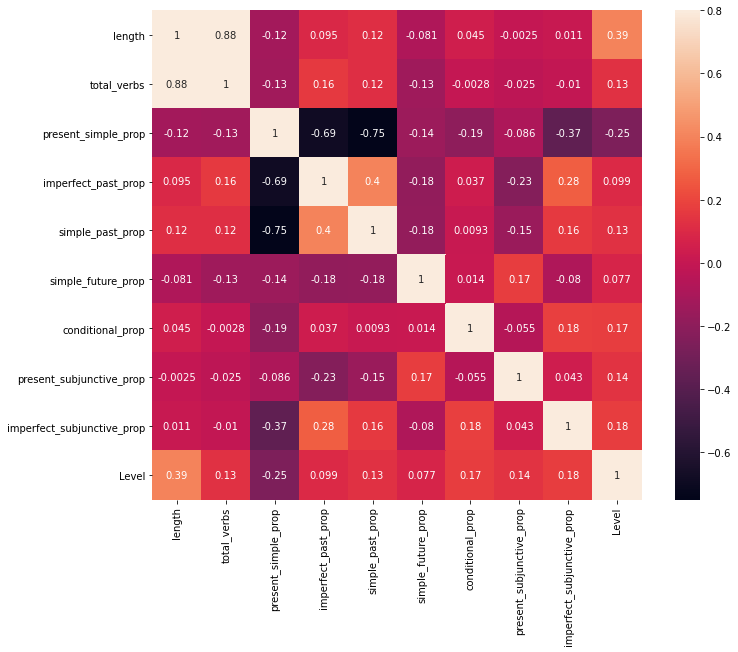

In [28]:
#Checking correlations against tense frequencies
df_freq = df.iloc[:, 11:22]
df_freq['Level'] = df['Level']

corrmat = df_freq.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True, vmax=.8, square=True, );

### Pivot tables for verb tenses proportions

In [29]:
#Imperfect Subjunctive Freq
df[['imperfect_subjunctive_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,imperfect_subjunctive_prop
5,6,0.023095
4,5,0.021371
3,4,0.020807
2,3,0.018046
1,2,0.007249
0,1,0.000813


In [30]:
#Present Simple Frequency
df[['present_simple_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,present_simple_prop
5,6,0.507368
4,5,0.501282
3,4,0.455547
2,3,0.530197
1,2,0.656607
0,1,0.849289


In [31]:
#Condtional
df[['conditional_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,conditional_prop
5,6,0.031392
4,5,0.022151
3,4,0.021814
2,3,0.023260
1,2,0.005456
0,1,0.008664


In [32]:
#Simple Future
df[['simple_future_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,simple_future_prop
5,6,0.042905
4,5,0.036646
3,4,0.048838
2,3,0.052281
1,2,0.020436
0,1,0.006244


In [33]:
#Simple Past
df[['simple_past_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,simple_past_prop
5,6,0.186586
4,5,0.176623
3,4,0.183236
2,3,0.169686
1,2,0.145096
0,1,0.045856


In [34]:
#present subjunctive
df[['present_subjunctive_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,present_subjunctive_prop
5,6,0.058520
4,5,0.067565
3,4,0.073762
2,3,0.051357
1,2,0.038385
0,1,0.037209


In [35]:
#Making boolean columns for whether or not a tense appears in the text:

def IsTensePresent(freq):
    if freq > 0:
        q=1
    else:
        q=0
    return q

df['is_imperfect_subjunctive'] = df['imperfect_subjunctive_total'].apply(lambda x: IsTensePresent(x))
df['is_present_subjunctive'] = df['present_subjunctive_total'].apply(lambda x: IsTensePresent(x))
df['is_present_simple'] = df['present_simple_total'].apply(lambda x: IsTensePresent(x))
df['is_future_simple'] = df['simple_future_total'].apply(lambda x: IsTensePresent(x))
df['is_past_simple'] = df['simple_past_total'].apply(lambda x: IsTensePresent(x))
df['is_imperfect_past'] = df['imperfect_past_total'].apply(lambda x: IsTensePresent(x))
df['is_condtional'] = df['conditional_total'].apply(lambda x: IsTensePresent(x))
df['is_gerund'] = df['gerund_total'].apply(lambda x: IsTensePresent(x))
df['is_imperative'] = df['imperative_total'].apply(lambda x: IsTensePresent(x))

df['is_imperfect_subjunctive'].value_counts()

0    370
1    208
Name: is_imperfect_subjunctive, dtype: int64

In [36]:
df[['is_imperfect_subjunctive', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_imperfect_subjunctive
5,6,0.536585
4,5,0.432990
3,4,0.423358
2,3,0.359375
1,2,0.163462
0,1,0.033333


In [37]:
df[['is_condtional', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_condtional
5,6,0.512195
4,5,0.453608
3,4,0.423358
2,3,0.390625
1,2,0.134615
0,1,0.166667


In [38]:
df[['is_past_simple', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_past_simple
5,6,0.878049
4,5,0.855670
3,4,0.781022
2,3,0.773438
1,2,0.740385
0,1,0.500000


In [39]:
df[['is_gerund', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_gerund
5,6,0.768293
4,5,0.731959
3,4,0.708029
2,3,0.593750
1,2,0.375000
0,1,0.400000


In [40]:
df[['is_present_subjunctive', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_present_subjunctive
5,6,0.804878
4,5,0.762887
3,4,0.781022
2,3,0.664062
1,2,0.557692
0,1,0.433333


### Initial analysis of tense correlations
The results were to be expected with some surprises. I thought that there would be a steady introduction of different verb tenses as you progress through the levels, however in reality even starting from A2 any verb tense might be present, albeit more complex tenses having a much lower lieklihood. This could be because people grading Spanish texts might allow some more complex verb tenses in lower level texts if they believe the reader can work out the meaning from context. In any case, there appears to be enough of a difference between levels for certain verb tenses that will prove useful for model building.

I will do more in depth statistical ananlysis later on to determine which results are significant and which is the best way to present the verb tense data, in frequency or in boolean form.

## Frequency of most common Spanish words
Here I will calculate what percentage of each text's words are one of the 1000 most common Spanish words (according to 1000mostcommonwords.com) or 100 most common verbs and their conjugations (according to spanishdict.com). This will theroretically shed light on the level of complexity of the text as the more difficult texts would use more unusual vocabulary.

I made a few edits to the 1000 most common Spanish words list (the most_common_spanish list below), removing words like articles and pronouns that will show up at any level in order to make the result more meaningful. The most common verb list includes the present, past, imperfect past, and future tense conjugations of each verb.

In [41]:
#Having scraped the list from 1000mostcommonwords, import to a dictionary here.
#I edited the list slightly, removing pronouns and connecting words that would appear at every level (30 or so words removed)
most_common_spanish = []
most_common_verbs = []

with open('./most_common_spanish2.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        word = line[:-1]

        # add item to the list
        most_common_spanish.append(word)
        
with open('./most_common_verbs.txt', 'r') as filehandle:
    for line in filehandle:
        verb = line[:-1]

        most_common_verbs.append(verb)
        
most_common_words = most_common_spanish + most_common_verbs
        
#Remove 'Spanish' which was an included header
most_common_words.remove('Spanish')

In [42]:
#determine percentage of common words
def CommonWords(text, most_common_words, length):
    common_words = [x for x in text if x in most_common_words]
    num_common_words = len(common_words)
    percentage = num_common_words/length
    return percentage

df['most_common_per'] = df.apply(lambda row: CommonWords(row['words_list'], most_common_words, row['length']), axis=1)

In [43]:
#Taking a look at the correlation and pivot table
df['Level'].corr(df['most_common_per'])

-0.32108558730064246

In [44]:
df[['most_common_per', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,most_common_per
5,6,0.222037
4,5,0.249973
3,4,0.282177
2,3,0.276889
1,2,0.283283
0,1,0.314085


### Percentage of most frequent words initial analysis
There is a negative correlation there, with A1 having the highest mean percentage and C2 having the lowest. However, as with the verb tenses, the numbers get a bit jumbled in the middle levels.

## Average Sentence Length
Calculating the average sentence length for each Text.

In [45]:
def AverageSentenceLength(words_list, z):
    terminals = set(['.', '?', '!']) # sets are efficient for "membership" tests
    terminal_count = 0
    
    #split at whitespace
    
    #To account for any double spacing both the last and second to last characters of each word are compared to the terminals
    for item in words_list:
        last_char = item[-2:]
        if last_char[-1:] in terminals or last_char[:1] in terminals: # here is our membership test
            terminal_count += 1
    
    #prevents breaking in case no terminals are present
    if terminal_count == 0:
        terminal_count = 1

    avg = len(words_list)  / float(terminal_count)

    return avg

In [46]:
#removing stray lone full stops from words_list as they will skew data
def RemoveFullStops(words_list):
    new_words_list = [x for x in words_list if x != '.']
    return new_words_list


df['new_words_list'] = df.apply(lambda row: RemoveFullStops(row['words_list']), axis=1)


In [47]:
df['av_sent_length'] = df.apply(lambda row: AverageSentenceLength(row['new_words_list'], row.name), axis=1)

In [48]:
print(df[df.av_sent_length > 30].av_sent_length)

300     32.642857
318     40.000000
358     34.555556
367     30.166667
369     81.000000
374     33.250000
377     30.772727
379     30.296296
385     39.117647
386     32.400000
394     31.750000
399     38.062500
403     31.400000
410     30.615385
412     31.250000
416     58.000000
419     34.200000
421     33.250000
423     47.818182
428     36.904762
429     31.580645
431     44.083333
434     32.769231
437     35.571429
439     35.833333
440     33.733333
448     30.714286
455     32.571429
468     51.166667
488    378.000000
526     68.250000
574     34.714286
Name: av_sent_length, dtype: float64


In [54]:
#Taking a look at the biggest values individually shows that the lengths above 60 are due to formatting erros
#for example because they are song lyrics or there are no spaces at the full stops
#These anomamlies will be deleted
print(df.loc[431].Level, df.loc[468].words_list)

6 ['Aguas', 'de', 'marzo', 'Es', 'palo', 'es', 'piedra', 'es', 'fin', 'de', 'camino', 'es', 'un', 'resto', 'de', 'leña', 'solitaria', 'y', 'perdida', 'es', 'trocito', 'de', 'vidrio', 'es', 'la', 'vida', 'es', 'el', 'sol', 'es', 'la', 'noche', 'la', 'muerte', 'es', 'un', 'lazo', 'un', 'arpón.', 'Es', 'un', 'árbol', 'de', 'campo', 'un', 'nudo', 'de', 'madera', 'Caingá', 'candela', 'Matita', 'Pereira', 'es', 'flauta', 'de', 'caña', 'alud', 'en', 'caída', 'un', 'misterio', 'profundo', 'es', 'un', 'quiera', 'y', 'no', 'quiera', 'es', 'un', 'viento', 'soplando', 'el', 'fin', 'de', 'la', 'ladera', 'es', 'la', 'viga', 'es', 'el', 'vano', 'fiesta', 'de', 'Cumeeira', 'es', 'la', 'lluvia', 'lloviendo', 'la', 'voz', 'de', 'la', 'ribera', 'de', 'las', 'aguas', 'de', 'marzo', 'es', 'el', 'fin', 'de', 'la', 'espera.', 'Es', 'pie', 'es', 'suelo', 'carretera', 'andarina', 'pajarito', 'en', 'la', 'mano', 'piedra', 'de', 'tirachinas', 'es', 'un', 'ave', 'en', 'el', 'cielo', 'es', 'un', 'ave', 'en', 'la',

In [55]:
#Removing the misformatted texts
df = df[df.av_sent_length < 60]

In [56]:
df['Level'].corr(df['av_sent_length'])

0.666306258441241

In [57]:
df[['av_sent_length', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,av_sent_length
5,6,26.948125
4,5,19.388384
3,4,15.867372
2,3,11.651772
1,2,10.093074
0,1,9.634074


### Initial analysis of sentence length
There correlation between sentence length and Level looks significant. It will likly be useful for the model.

## Percentage of unique words in the text
Extracts the total number of unique words and divides by the length.

In [60]:
def UniqueWords(new_words_list):
    #Remove all punctuation as this will make the string look different
    stripped_list = [x.strip('?!.)(;:-') for x in new_words_list]
    #Put every character in lower case
    stripped_list = [x.lower() for x in stripped_list]
    text_set = set(stripped_list)
    unique_word_prop = len(text_set)/len(stripped_list)
    return unique_word_prop
    
    

In [61]:
df['unique_word_prop'] = df.apply(lambda row: UniqueWords(row['new_words_list']), axis=1)

In [62]:
#Taking a look at the mean values
pd.pivot_table(df, index ='Level', values=['unique_word_prop', 'length'])

,length,unique_word_prop
Level,,
1,196.933333,0.595841
2,271.631068,0.523717
3,314.000000,0.554777
4,368.029197,0.558674
5,425.927835,0.545421
6,515.382716,0.522917


The results here do not seem significant at all. The lower levels have a higher mean proportion of unique words in their texts which is opposite to what was expected. In hindsight, length of the text is likely the driving factor for this value rather than level. Words that occur every sentence in all levels such as pronouns or articles will gradually decrease the calculated number as length increases even though their proportion per sentence might stay the same. Given length increases with level, the proportion of unique words will in turn decrease. This could be corrected by extracting those super common words before doing the calculation but based on the initial numbers it still wouldn't be useful. This feature won't be included in the model.

## Moving on to more in-depth analysis
Now that the feature's have been enigeered I will move on to do some further cleaning, feature selection and ultimately model building. This will be in the analysis_and_model notebook.

In [63]:
df.to_csv('texts_with_features.csv', index=False, header=True)